Data fields:

Access_ID - Unique identification of the user access to the website

Date - Website visit date

AccountMng_Pages - Number of pages visited by the user about account management

AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages

FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages

FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages

Product_Pages - Number of pages visited by the user about products and services offered by the company

Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages

GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics

OS - Operating System of the user

Browser - Browser used to access the webpage

Country - The country of the user

Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)

Type_of_Visitor - User type as "New access", "Returner" or "Other"

Buy - Class label indicating if the user finalized their actions in the website with a transaction

In [151]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [171]:
# importing datasets
#df_train = pd.read_csv('../data/train.csv')
#df_test = pd.read_csv('../data/test.csv')
sub_smp = pd.read_csv('../data/sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [5]:
df_train.head()

## existe forma de calcular o id do utilizador pelo Access_ID?
## temos a descrição das categorias para o browser e type of traffic?

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [56]:
# set access ID as index
df_train.set_index('Access_ID', inplace = True)

In [57]:
# check if we have duplicates
df_train.duplicated().sum()

14

In [58]:
# remove duplicates
df_train.drop_duplicates(keep='first', inplace=True)

In [59]:
# confirm
df_train.duplicated().sum()

0

In [60]:
round(df_train.Buy.mean(),3)*100 # we have an average conversion rate of 15.5%

15.5

In [61]:
# change types

# from object to date
df_train.Date = df_train.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

In [62]:
#confirm
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9985 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9985 non-null   datetime64[ns]
 1   AccountMng_Pages            9985 non-null   int64         
 2   AccountMng_Duration         9985 non-null   float64       
 3   FAQ_Pages                   9985 non-null   int64         
 4   FAQ_Duration                9985 non-null   float64       
 5   Product_Pages               9985 non-null   int64         
 6   Product_Duration            9985 non-null   float64       
 7   GoogleAnalytics_BounceRate  9985 non-null   float64       
 8   GoogleAnalytics_ExitRate    9985 non-null   float64       
 9   GoogleAnalytics_PageValue   9985 non-null   float64       
 10  OS                          9985 non-null   object        
 11  Browser                     9985 non-null  

In [63]:
# get details from the date
df_train['Month_Access'] = df_train.Date.apply(lambda x: x.month)
df_train['Day_Access'] = df_train.Date.apply(lambda x: x.day)
df_train['WDay_Access'] = df_train.Date.apply(lambda x: x.weekday()) ## monday is 0

In [64]:
# calculate new variables

# total number of pages visited and total durantion of visits
df_train['Total_Pages'] = df_train['AccountMng_Pages']+df_train['FAQ_Pages']+df_train['Product_Pages']
df_train['Total_Duration'] = df_train['AccountMng_Duration']+df_train['FAQ_Duration']+df_train['Product_Duration']

# proportion of visits by each pages and duration
df_train['Prop_AccountMng_Pages'] = df_train['AccountMng_Pages']/df_train['Total_Pages']
df_train['Prop_FAQ_Pages'] = df_train['FAQ_Pages']/df_train['Total_Pages']
df_train['Prop_Product_Pages'] = df_train['Product_Pages']/df_train['Total_Pages']

df_train['Prop_AccountMng_Duration'] = df_train['AccountMng_Duration']/df_train['Total_Duration']
df_train['Prop_FAQ_Duration'] = df_train['FAQ_Duration']/df_train['Total_Duration']
df_train['Prop_Product_Duration'] = df_train['Product_Duration']/df_train['Total_Duration']

# averages times spent in each page
df_train['Avg_AccountMng_Duration'] = df_train['AccountMng_Duration']/df_train['AccountMng_Pages']
df_train['Avg_AccountMng_Duration'] = df_train['FAQ_Duration']/df_train['FAQ_Pages']
df_train['Avg_AccountMng_Duration'] = df_train['Product_Duration']/df_train['Product_Pages']

# total average
df_train['Avg_Duration'] = df_train['Total_Duration']/df_train['Total_Pages']

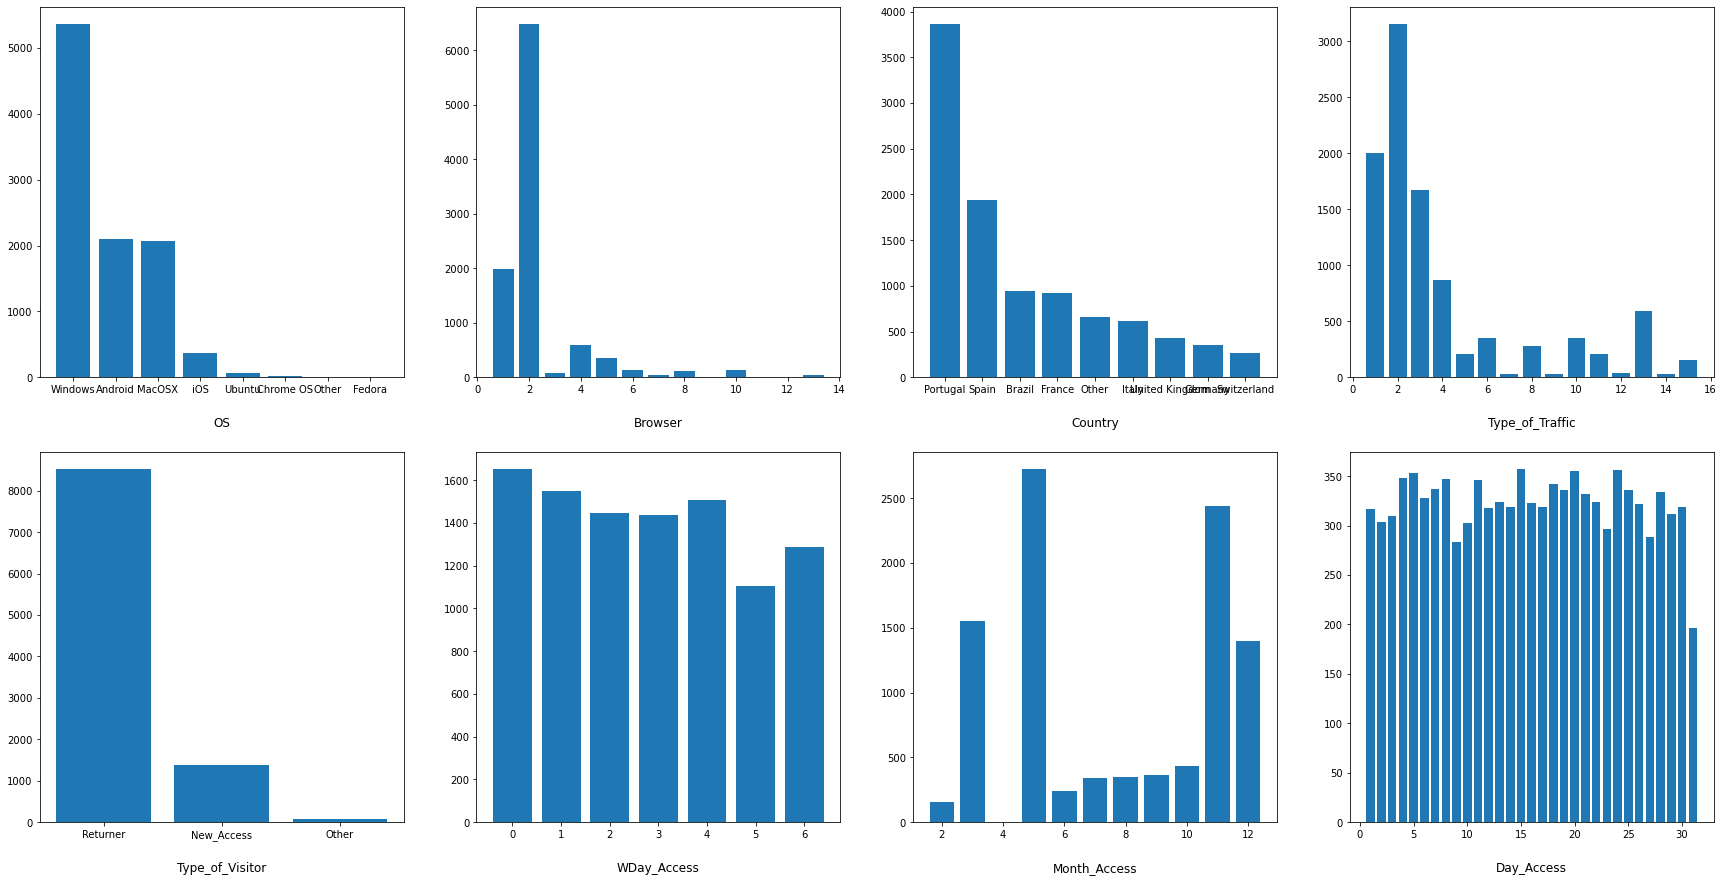

In [28]:

## distribution of categorical variables

cat_vars = ['OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access','Month_Access','Day_Access']

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(cat_vars) / 2), figsize=(30, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), cat_vars): # Notice the zip() function and flatten() method
    ax.bar(height=list(df_train[feat].value_counts()), x=list(df_train[feat].value_counts().index))
    ax.set_title(feat, y=-0.15)
plt.show()
    


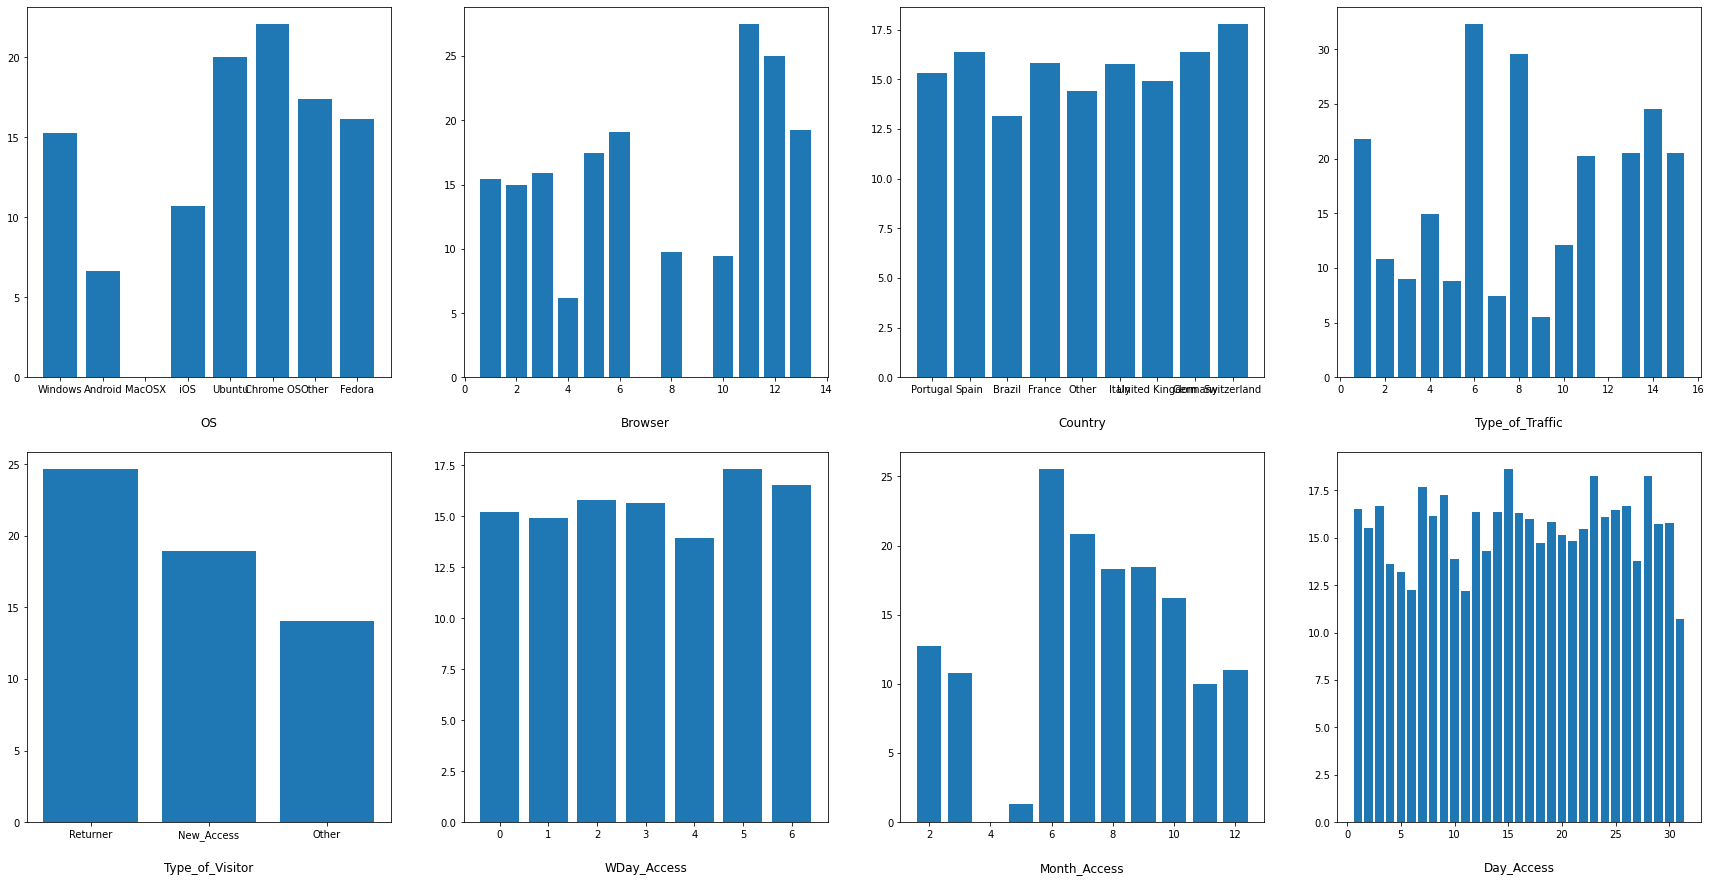

In [29]:
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(cat_vars) / 2), figsize=(30, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), cat_vars): # Notice the zip() function and flatten() method
    ax.bar(height=list(df_train.groupby(feat).Buy.agg('mean')*100), x=list(df_train[feat].value_counts().index))
    ax.set_title(feat, y=-0.15)
plt.show()
    

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9985 entries, 102863333 to 798444008
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9985 non-null   datetime64[ns]
 1   AccountMng_Pages            9985 non-null   int64         
 2   AccountMng_Duration         9985 non-null   float64       
 3   FAQ_Pages                   9985 non-null   int64         
 4   FAQ_Duration                9985 non-null   float64       
 5   Product_Pages               9985 non-null   int64         
 6   Product_Duration            9985 non-null   float64       
 7   GoogleAnalytics_BounceRate  9985 non-null   float64       
 8   GoogleAnalytics_ExitRate    9985 non-null   float64       
 9   GoogleAnalytics_PageValue   9985 non-null   float64       
 10  OS                          9985 non-null   object        
 11  Browser                     9985 non-null  

In [66]:
df_train.head()

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Total_Pages,Total_Duration,Prop_AccountMng_Pages,Prop_FAQ_Pages,Prop_Product_Pages,Prop_AccountMng_Duration,Prop_FAQ_Duration,Prop_Product_Duration,Avg_AccountMng_Duration,Avg_Duration
Access_ID,,,,,,,,,,,,,,,,,,,,,
102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,...,3,64.0000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,21.333333,21.333333
103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,...,23,684.5000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,29.760870,29.760870
103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,...,8,95.0000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,11.875000,11.875000
103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,...,9,608.7500,0.0,0.000000,1.000000,0.0,0.000000,1.000000,67.638889,67.638889
103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,...,38,1995.9397,0.0,0.052632,0.947368,0.0,0.193393,0.806607,44.720547,52.524729


In [67]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9985.0,2.327491,3.341883,0.0,0.000000,1.000000,4.000000,27.0000
AccountMng_Duration,9985.0,81.319713,179.815757,0.0,0.000000,8.000000,92.562500,3398.7500
FAQ_Pages,9985.0,0.508763,1.280145,0.0,0.000000,0.000000,0.000000,24.0000
FAQ_Duration,9985.0,34.607557,139.888975,0.0,0.000000,0.000000,0.000000,2549.3750
Product_Pages,9985.0,31.728893,44.566669,0.0,7.000000,18.000000,38.000000,705.0000
Product_Duration,9985.0,1201.451630,1959.133019,0.0,184.600000,600.000000,1471.858300,63973.5222
GoogleAnalytics_BounceRate,9985.0,0.022056,0.048354,0.0,0.000000,0.003100,0.016700,0.2000
GoogleAnalytics_ExitRate,9985.0,0.042962,0.048525,0.0,0.014300,0.025100,0.050000,0.2000
GoogleAnalytics_PageValue,9985.0,5.971481,18.765439,0.0,0.000000,0.000000,0.000000,361.7637
Browser,9985.0,2.352328,1.713344,1.0,2.000000,2.000000,2.000000,13.0000


In [68]:
## encoding

dummy_os = pd.get_dummies(df_train['OS'], prefix='OS')
dummy_browser = pd.get_dummies(df_train['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(df_train['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(df_train['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(df_train['Type_of_Visitor'], prefix='Visitor')
dummy_wday = pd.get_dummies(df_train['WDay_Access'], prefix='Wday')

df_train = pd.concat([df_train, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor, dummy_wday], axis=1)

In [69]:
df_train.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access'], axis=1, inplace=True)

In [70]:
df_train.head()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Buy,...,Visitor_New_Access,Visitor_Other,Visitor_Returner,Wday_0,Wday_1,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6
Access_ID,,,,,,,,,,,,,,,,,,,,,
102863333,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,0,...,0,0,1,0,0,0,0,0,1,0
103117814,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,0,...,0,0,1,0,0,1,0,0,0,0
103201891,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,0,...,0,0,1,0,0,0,0,1,0,0
103226087,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,1,...,0,0,1,0,1,0,0,0,0,0
103234445,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,1,...,0,0,1,0,1,0,0,0,0,0


In [71]:
X = df_train.drop('Buy',axis=1)
y = df_train['Buy']

In [104]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9985 entries, 102863333 to 798444008
Data columns (total 75 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AccountMng_Pages            9985 non-null   int64  
 1   AccountMng_Duration         9985 non-null   float64
 2   FAQ_Pages                   9985 non-null   int64  
 3   FAQ_Duration                9985 non-null   float64
 4   Product_Pages               9985 non-null   int64  
 5   Product_Duration            9985 non-null   float64
 6   GoogleAnalytics_BounceRate  9985 non-null   float64
 7   GoogleAnalytics_ExitRate    9985 non-null   float64
 8   GoogleAnalytics_PageValue   9985 non-null   float64
 9   Month_Access                9985 non-null   int64  
 10  Day_Access                  9985 non-null   int64  
 11  Total_Pages                 9985 non-null   int64  
 12  Total_Duration              9985 non-null   float64
 13  Prop_AccountMng_Page

In [105]:
## undersampling
# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# X_under, y_under = undersample.fit_resample(X, y)

In [107]:
# y_under.mean()*100

50.0

In [109]:
#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42, stratify=y_under)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [110]:
print(y_train.mean())
print(y_test.mean())

0.15538703677207039
0.15554072096128171


In [113]:
print(X_train.shape)
print(X_test.shape)

(6989, 75)
(2996, 75)


In [114]:
X_train.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [183]:
## initiate model
GradientBoost1 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=3, random_state=93)

In [96]:
#scores = cross_val_score(GradientBoost1, X_train, y, cv=5, scoring='f1')
print(scores)
print("%0.2f f1_score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.64 f1_score with a standard deviation of 0.02


In [184]:
GradientBoost1 = GradientBoost1.fit(X_train,y_train)

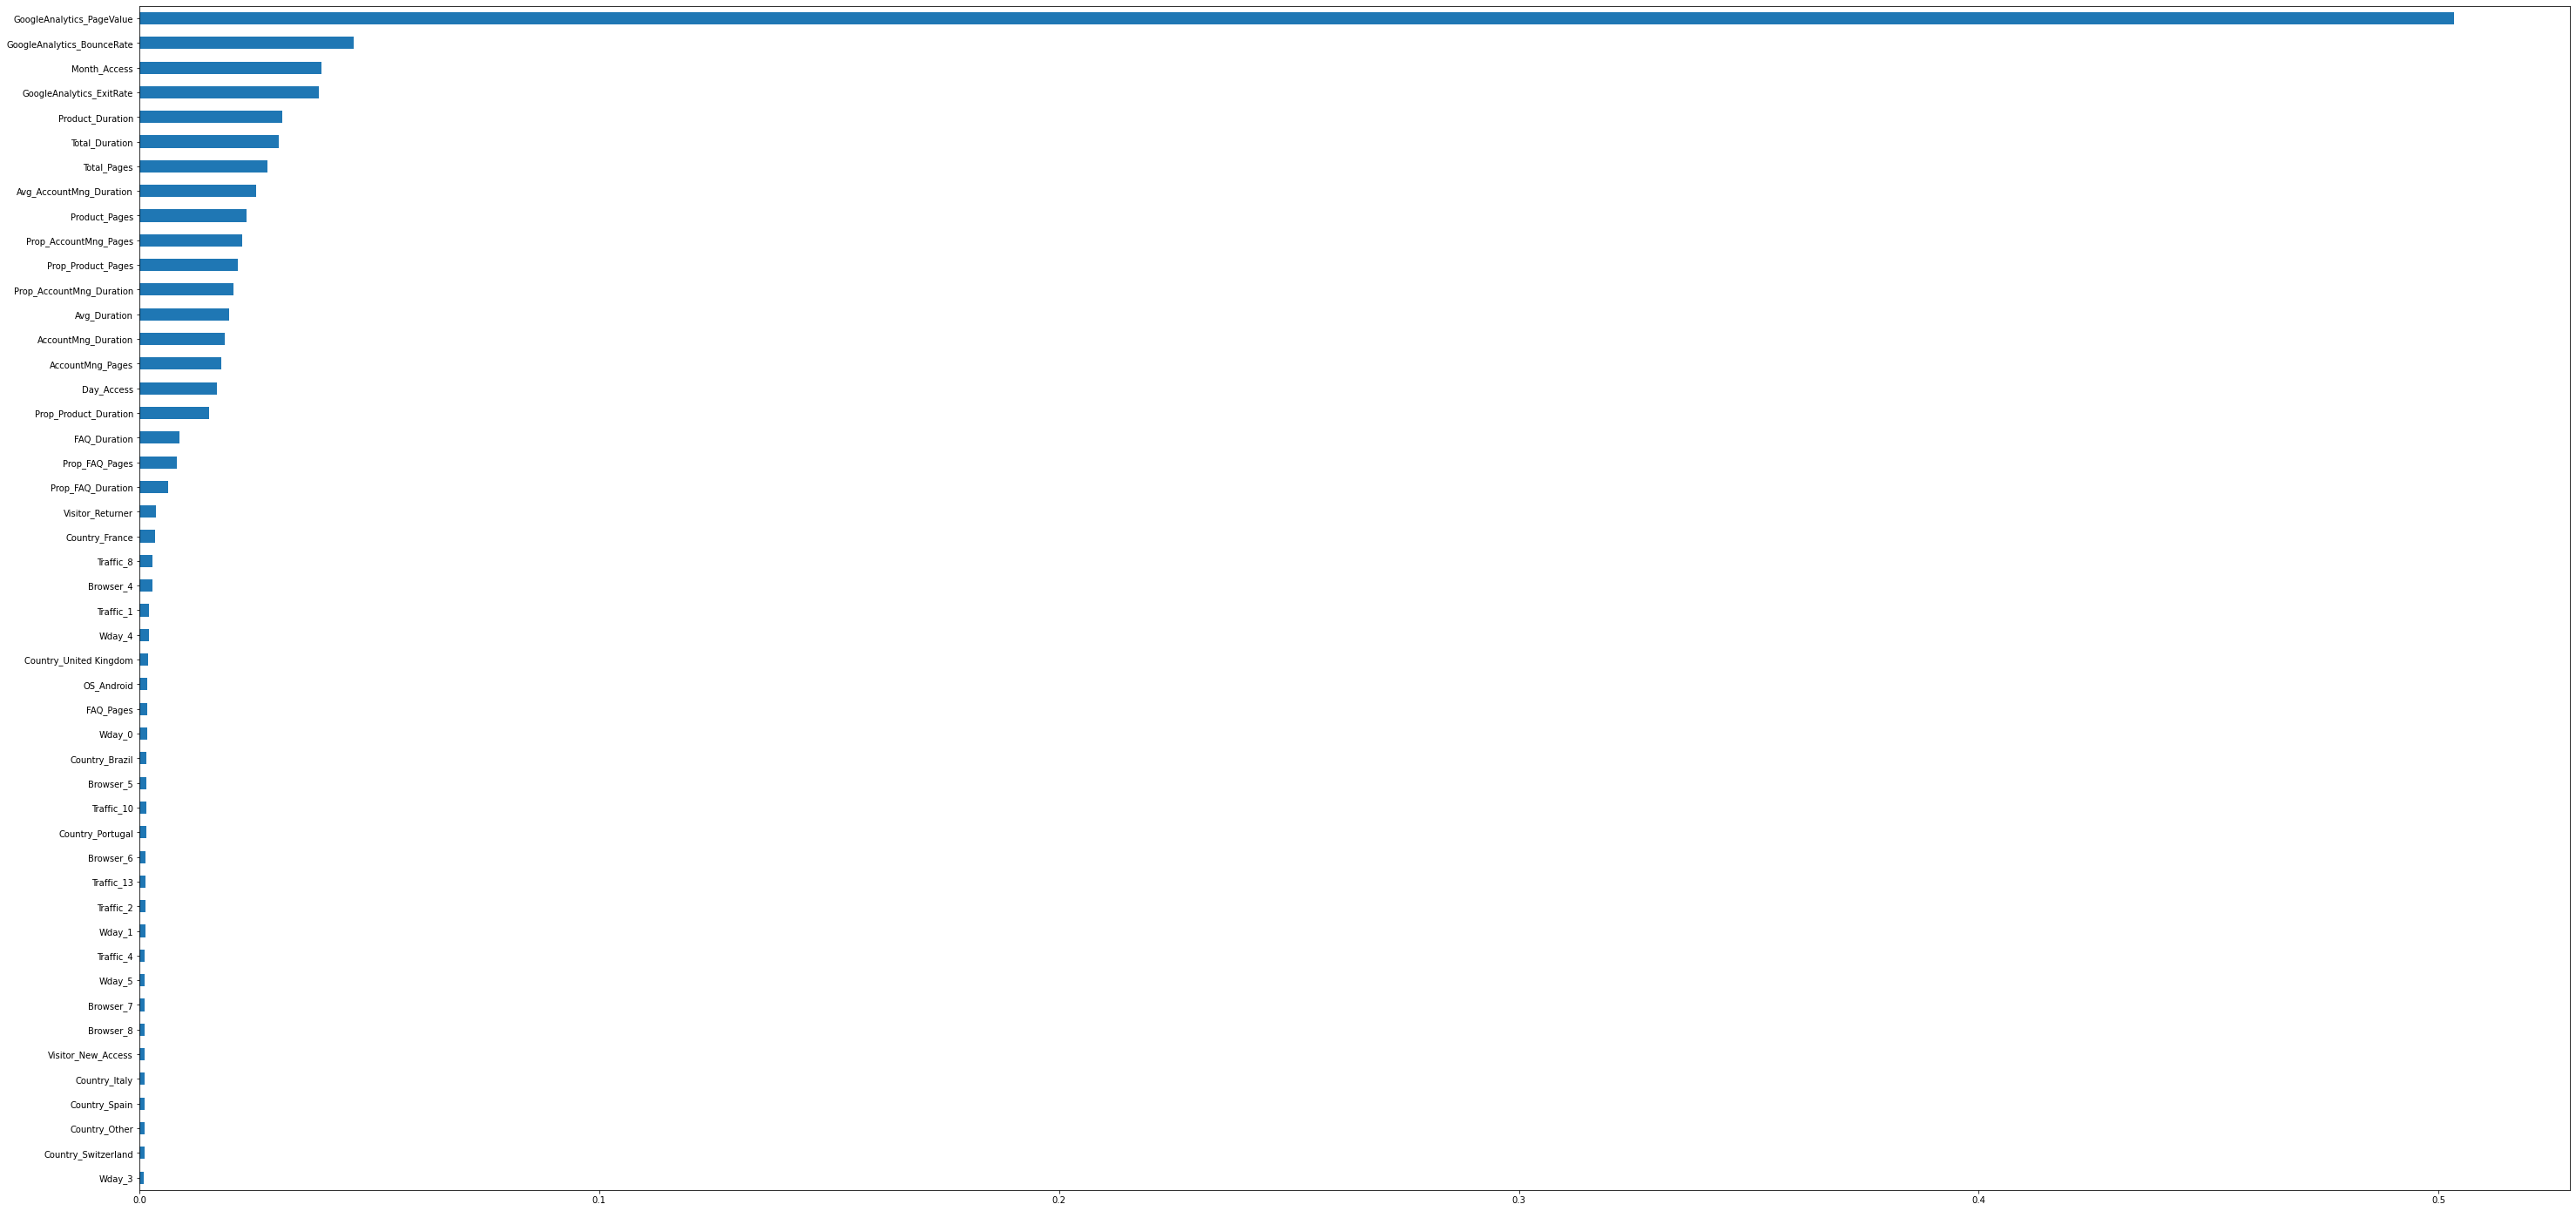

In [124]:
GB1_feat_imprt = pd.Series(GradientBoost1.feature_importances_, index=X.columns).sort_values()
fig = plt.figure(figsize=(50,25))
GB1_feat_imprt[GB1_feat_imprt>0.001].plot(kind='barh')
plt.show()

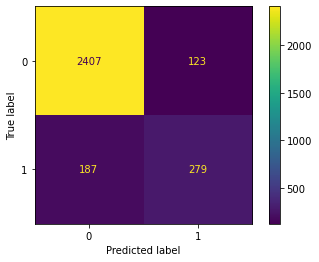

In [125]:
metrics.plot_confusion_matrix(GradientBoost1, X_test, y_test)  

In [185]:
GB1_train_pred = GradientBoost1.predict(X_train)
GB1_train_score = GradientBoost1.predict_proba(X_train)[:,1]

In [188]:
print('Precision: '+ str(round(metrics.precision_score(y_train, GB1_train_pred),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, GB1_train_pred),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, GB1_train_pred),3)))

Precision: 1.0
Recall: 0.999
F1 Score: 1.0


In [189]:
GB1_pred = GradientBoost1.predict(X_test)
GB1_score = GradientBoost1.predict_proba(X_test)[:,1]

In [190]:
print('Precision: '+ str(round(metrics.precision_score(y_test, GB1_pred),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, GB1_pred),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, GB1_pred),3)))


Precision: 0.661
Recall: 0.603
F1 Score: 0.631


In [161]:
## prepair test data

# set access ID as index
df_test.set_index('Access_ID', inplace = True)

# data for submission
df_test.Date = df_test.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

# get details from the date
df_test['Month_Access'] = df_test.Date.apply(lambda x: x.month)
df_test['Day_Access'] = df_test.Date.apply(lambda x: x.day)
df_test['WDay_Access'] = df_test.Date.apply(lambda x: x.weekday()) ## monday is 0

# total number of pages visited and total durantion of visits
df_test['Total_Pages'] = df_test['AccountMng_Pages']+df_test['FAQ_Pages']+df_test['Product_Pages']
df_test['Total_Duration'] = df_test['AccountMng_Duration']+df_test['FAQ_Duration']+df_test['Product_Duration']

# proportion of visits by each pages and duration
df_test['Prop_AccountMng_Pages'] = df_test['AccountMng_Pages']/df_test['Total_Pages']
df_test['Prop_FAQ_Pages'] = df_test['FAQ_Pages']/df_test['Total_Pages']
df_test['Prop_Product_Pages'] = df_test['Product_Pages']/df_test['Total_Pages']

df_test['Prop_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['Total_Duration']
df_test['Prop_FAQ_Duration'] = df_test['FAQ_Duration']/df_test['Total_Duration']
df_test['Prop_Product_Duration'] = df_test['Product_Duration']/df_test['Total_Duration']

# averages times spent in each page
df_test['Avg_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['AccountMng_Pages']
df_test['Avg_AccountMng_Duration'] = df_test['FAQ_Duration']/df_test['FAQ_Pages']
df_test['Avg_AccountMng_Duration'] = df_test['Product_Duration']/df_test['Product_Pages']

# total average
df_test['Avg_Duration'] = df_test['Total_Duration']/df_test['Total_Pages']

## encoding

dummy_os = pd.get_dummies(df_test['OS'], prefix='OS')
dummy_browser = pd.get_dummies(df_test['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(df_test['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(df_test['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(df_test['Type_of_Visitor'], prefix='Visitor')
dummy_wday = pd.get_dummies(df_test['WDay_Access'], prefix='Wday')

df_test = pd.concat([df_test, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor, dummy_wday], axis=1)

df_test.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access'], axis=1, inplace=True)

df_test.fillna(0, inplace=True)

df_test = df_test[X_train.columns]

In [141]:
#df_test.drop('Propensity', axis=1, inplace=True)

In [163]:
df_test['Propensity'] = GradientBoost1.predict_proba(df_test)[:,1]

In [164]:
df_test['Buy'] = np.where(df_test['Propensity']>0.15,1,0)

In [176]:
sub_smp

""
Access_ID
798519314
798663101
798663221
798760918
798856982
...
962042726
962063064
962147749


In [173]:
sub_smp.set_index('Access_ID',inplace=True)


In [175]:
sub_smp.drop('Buy', axis=1, inplace=True)

In [177]:
sub_smp = pd.concat([sub_smp,df_test['Buy']], axis=1)

In [179]:
sub_smp.reset_index(inplace=True)

In [182]:
sub_smp.to_csv('submission.csv', index=False)